# 3. Finding roots

In [1]:
using IntervalArithmetic

We now know how to calculate an enclosure of the range of a function $f$ over an interval $X$: we evaluate $f(X)$ using interval arithmetic.

How can we use this to do something useful?

One key question that crops up all the time in scientific computing is finding the **roots** or **zeros** of a function $f$, i.e. the special values $x = x^*$ such that $f(x^*) = 0$. For example, to solve the equation $x = \sin(x)$ we can rewrite this as $x - \sin(x) = 0$, so that solutions of the equation correspond to roots of the function $f(x) = x - \sin(x)$.

Let's start with a simple function:

In [2]:
f(x) = x^2 - 2

f (generic function with 1 method)

In [3]:
using Plots

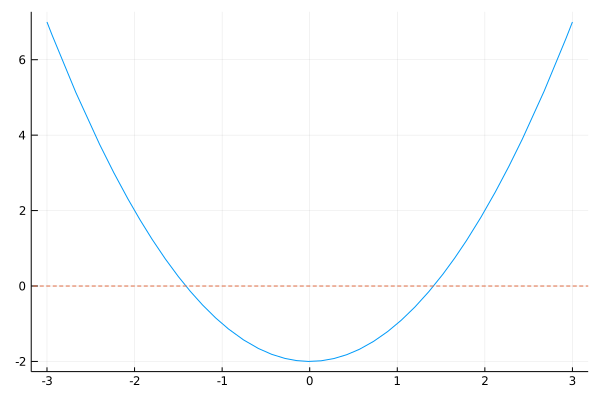

In [4]:
plot(f, -3, 3, leg=false)
hline!([0], ls=:dash)

We see that there are two roots; we know from algebra that these are at $\pm \sqrt{2} \simeq \pm 1.414\ldots$. How could we find those roots without prior knowledge?

Let's start near the root, for example with the interval

In [6]:
X = 1..2

[1, 2]

We get

In [7]:
f(X)

[-1, 2]

In [8]:
0 ∈ f(X)   # \in <TAB>

true

So $0$ is contained in $f(X)$. However, we *cannot* conclude anything from this, since this enclosure may be an *over*-estimate of the true range.

#### Exercise: 

Find a quadratic function that you know is $> 0$ everywhere, but which gives an interval containing $0$ when evaluated using interval arithmetic.

$(x - 2)^2 + 1$

In [9]:
g(x) = x^2 - 4x + 5

g (generic function with 1 method)

In [10]:
g(-5..5)

[-15, 50]

Now let's try a region away from the root:

In [11]:
X = 3..4

[3, 4]

This gives the range

In [13]:
f(x) = x^2 - 2

f (generic function with 1 method)

In [14]:
f(X)

[7, 14]

So

In [15]:
0 ∈ f(X)    # type \in<TAB>

false

Can we conclude anything from this? We see that $0 \notin f(X)$, so $0 \in f(X)^c$, where $Y^c := \mathbb{R} \setminus Y$ denotes the set complement of $Y$. But $\text{range}(f; X) \subseteq f(X)$, and hence $f(X)^c \subseteq \text{range}(f; X)^c$. Thus $0 \in \text{range}(f; X)^c$, i.e. $0 \notin \text{range}(f; X)$.

Hence we see that our numerical calculation with floating-point arithmetic gives a *mathematically rigorous guarantee* that there cannot be any roots of $f$ in the interval $X$. We call this *excluding* a root.

#### Exercise
1. Experiment with different intervals to see how far you can exclude roots.

In [16]:
diam(f(X))

7.0

In [17]:
f(3..5)

[7, 23]

In [18]:
f(3..100)

[7, 9998]

In [19]:
f(3..1e8)

[7, 1e+16]

In [20]:
f(3..∞)  # \infty<TAB>

[7, ∞]

In [21]:
0 ∈ f(3..∞)

false

In [22]:
0 ∈ f(-∞..(-3))

false

In [23]:
mince(3..∞, 10)

ArgumentError: ArgumentError: start and stop must be finite, got 3.0 and Inf

In [24]:
interval(prevfloat(Inf), Inf)

[1.79769e+308, ∞]

## Existence and uniqueness of a root

So far we have found an **exclusion region**, where we have been able to show that $f$ has *no* roots. How could we prove that $f$ *does* have a root?

In 1D there is a well-known test for this.

#### Exercise

1. Recall from calculus (if you have taken it) that there is a theorem that guarantees that a 1D function crosses $0$. Which theorem is it and what are the conditions for it to be satisfied.


2. However, this result could allow for there to be *many* roots in the given interval. What mathematical condition will guarantee that there is a *unique* root? How could we use this on the computer?

Intermediate value thm for continuous functions:

In [25]:
f(1), f(2)

(-1, 2)

In [26]:
sign(f(1)) != sign(f(2))

true

Unique if $f'$ is bounded away from 0, i.e. $f'(x) \neq 0$ for all $x \in X$

In [27]:
f′(x) = 2x

f′ (generic function with 1 method)

In [29]:
f′(X)

[6, 8]

In [30]:
0 ∈ f′(X)

false

So monotone, so unique root!

## Algorithmic differentiation

In order to prove uniqueness of a root for a 1D function in a given interval $X$, we need to know that the function is **strictly monotone**, either increasing or decreasing. That is (assuming differentiability) we need to show that $f'(x) \neq 0$ for all $x \in X$, where $f'(x)$ is the derivative of $f$ at $x$.

This is just the same problem as excluding roots: now we need to exclude roots of the function $f'$ on the interval $X$! The "only" difficulty, then, is how to calculate $f'$. 

Fortunately, the technique of **algorithm differentiation** (or **automatic differentiation**) provides the solution. We don't have time to go over how this technique works: we will just treat it as a **black box**, provided by a Julia package.

There are several possible Julia packages that implement both forward- and reverse-mode algorithmic differentiation. We will use `ForwardDiff.jl`, which uses the algebra of **dual numbers**, $a + b \epsilon$ with $\epsilon^2 = 0$, to calculate *exact* derivatives numerically (up to floating-point round-off error).

In [31]:
using ForwardDiff

For a Julia function `f` we can calculate its derivative at `x` using

In [32]:
f(x) = x^2 - 2
x = 3.0

ForwardDiff.derivative(f, x)    # should be 2x

6.0

We can make a higher-order derivative function as follows:

In [33]:
derivative(f) = x -> ForwardDiff.derivative(f, x)  

derivative (generic function with 1 method)

[It is possible to extend `'` to mean derivative, as is done e.g. in `ApproxFun.jl`.]

The amazing thing is that we can now use `ForwardDiff` and pass in an *interval* for `x`. Due to the way that algorithmic differentiation works, and the fact that the package has been written in a very generic way, each internal calculation will now produce intervals with the enclosure property, *also* for the derivatives. The end result is:

In [34]:
ForwardDiff.derivative(f, 1..2)

[2, 4]

which is guaranteed to be an *enclosure* of $\text{range}(f', X)$, the range of the derivative over $X$.

Since this interval is strictly positive, we have proved that $f$ is strictly increasing in that interval. 
Since it is also continuous and changes sign:

In [ ]:
f(1), f(2)

we have *proved* that there is a unique root of $f$ in $[1, 2]$!